In [1]:
from math import sqrt
from datetime import datetime
import numpy as np
import pandas as pd
from pandas import read_excel
import math
from numpy import concatenate
from pandas import concat
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.svm import SVR
plt.style.use('fivethirtyeight')

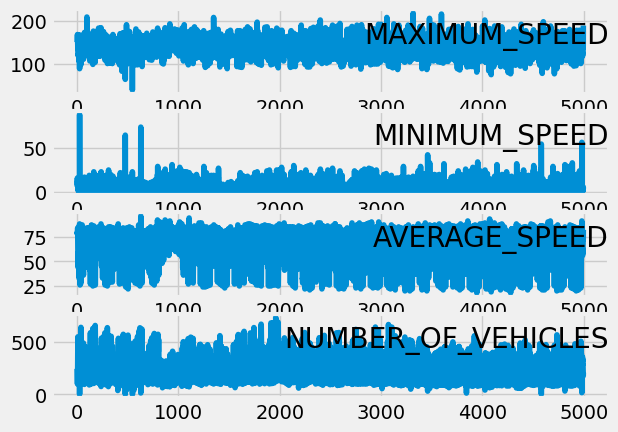

In [2]:
# load dataset
dataset = read_excel(r'C:\sxk9gd_2_6ay.xlsx', header=0, index_col=0)
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure()
for group in groups:
 pyplot.subplot(len(groups), 1, i)
 pyplot.plot(values[:, group])
 pyplot.title(dataset.columns[group], y=0.5, loc='right')
 i += 1
pyplot.show()

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
                cols.append(df.shift(i))
                names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
                cols.append(df.shift(-i))
                if i == 0:
                        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
                else:
                        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
                agg.dropna(inplace=True)
        return agg

In [4]:
# specify the number of lag hours
n_hours = 6
n_steps = 3
n_features = 4
n_obs = n_hours * n_features
n_x = (n_hours * n_features) - n_steps
# frame as supervised learning
reframed = series_to_supervised(values, n_hours, n_steps)
# drop columns we don't want to predict

for i in range (0,n_steps):
   reframed.drop(reframed.columns[[n_obs+i,n_obs+i+1,n_obs+i+3]], axis=1, inplace=True) 

reframed

var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var1(t-5)  var2(t-5)  \
6         151.0        6.0       77.0      243.0      155.0        6.0   
7         155.0        6.0       78.0      159.0      166.0       16.0   
8         166.0       16.0       80.0      112.0      169.0        9.0   
9         169.0        9.0       78.0       99.0      158.0        8.0   
10        158.0        8.0       78.0      113.0      155.0       13.0   
...         ...        ...        ...        ...        ...        ...   
4991      133.0        3.0       65.0      331.0      132.0        4.0   
4992      132.0        4.0       63.0      330.0      139.0        2.0   
4993      139.0        2.0       64.0      359.0      124.0        2.0   
4994      124.0        2.0       57.0      357.0      127.0        1.0   
4995      127.0        1.0       57.0      310.0      119.0        1.0   

      var3(t-5)  var4(t-5)  var1(t-4)  var2(t-4)  ...  var2(t-2)  var3(t-2)  \
6          78.0      159.0      166.0       16.0  ...        8.0       78.0   
7          80.0      112.0      169.0        9.0  ...       13.0       84.0   
8          78.0       99.0      158.0        8.0  ...        5.0       76.0   
9          78.0      113.0      155.0       13.0  ...        3.0       61.0   
10         84.0      282.0      144.0        5.0  ...        2.0       47.0   
...         ...        ...        ...        ...  ...        ...        ...   
4991       63.0      330.0      139.0        2.0  ...        1.0       57.0   
4992       64.0      359.0      124.0        2.0  ...        1.0       56.0   
4993       57.0      357.0      127.0        1.0  ...        3.0       62.0   
4994       57.0      310.0      119.0        1.0  ...        2.0       59.0   
4995       56.0      339.0      124.0        3.0  ...        3.0       65.0   

      var4(t-2)  var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var3(t)  \
6         113.0      155.0       13.0       84.0      282.0     76.0   
7         282.0      144.0        5.0       76.0      434.0     61.0   
8         434.0      133.0        3.0       61.0      547.0     47.0   
9         547.0      154.0        2.0       47.0      348.0     44.0   
10        348.0      152.0        2.0       44.0      301.0     54.0   
...         ...        ...        ...        ...        ...      ...   
4991      310.0      119.0        1.0       56.0      339.0     62.0   
4992      339.0      124.0        3.0       62.0      282.0     59.0   
4993      282.0      129.0        2.0       59.0      285.0     65.0   
4994      285.0      142.0        3.0       65.0      289.0     71.0   
4995      289.0      143.0        2.0       71.0      243.0     73.0   

      var3(t+1)  var3(t+2)  
6          61.0       47.0  
7          47.0       44.0  
8          44.0       54.0  
9          54.0       59.0  
10         59.0       56.0  
...         ...        ...  
4991       59.0       65.0  
4992       65.0       71.0  
4993       71.0       73.0  
4994       73.0       72.0  
4995       72.0       82.0  

[4990 rows x 27 columns]

In [5]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = scaler.fit_transform(reframed)

In [6]:
# split into train and test sets
# %60 Train % 40 Test
TRAIN_SIZE = 0.60
train = reframed[:int(len(reframed)*TRAIN_SIZE), :]
test = reframed[int(len(reframed)*TRAIN_SIZE):, :]

# split into input and outputs
n_obs = n_hours * n_features
x_train, y_train = train[:, :n_obs], train[:, -n_steps:]
x_test, y_test = test[:, :n_obs], test[:, -n_steps:]
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, len(x_test))

(2994, 24) (2994, 3) (1996, 24) (1996, 3) 1996


In [7]:
model = SVR(kernel='rbf',gamma=0.75, C=10, epsilon = 0.005)
model.fit(x_train, y_train[:,0])
model1 = SVR(kernel='rbf',gamma=0.75, C=10, epsilon = 0.005)
model1.fit(x_train, y_train[:,1])
model2 = SVR(kernel='rbf',gamma=0.75, C=10, epsilon = 0.005)
model2.fit(x_train, y_train[:,2])
SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.005, gamma=10.05,
    kernel='rbf', max_iter=5000, shrinking=True, tol=0.001, verbose=False)

SVR(C=100, epsilon=0.005, gamma=10.05, max_iter=5000)

In [8]:
model.get_params()

{'C': 10,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.005,
 'gamma': 0.75,
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [9]:
y1_train_pred = model.predict(x_train).reshape(-1,1)
y2_train_pred = model1.predict(x_train).reshape(-1,1)
y3_train_pred = model2.predict(x_train).reshape(-1,1)
y1_test_pred = model.predict(x_test).reshape(-1,1)
y2_test_pred = model1.predict(x_test).reshape(-1,1)
y3_test_pred = model2.predict(x_test).reshape(-1,1)
y_train_pred = concatenate(( y1_train_pred, y2_train_pred, y3_train_pred), axis=1)
y_test_pred = concatenate(( y1_test_pred, y2_test_pred, y3_test_pred), axis=1)


In [10]:
# Scaling the predictions
y_train_pred = concatenate((x_train[:, -n_obs:], y_train_pred), axis=1)
y_train_pred = scaler.inverse_transform(y_train_pred)
y_train_pred = y_train_pred[:,-n_steps:]

y_test_pred = concatenate((x_test[:, -n_obs:], y_test_pred), axis=1)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_test_pred = y_test_pred[:,-n_steps:]


In [11]:
# Scaling the original values
y_train = concatenate((x_train[:, -n_obs:], y_train), axis=1)
y_train = scaler.inverse_transform(y_train)
y_train = y_train[:,-n_steps:]

y_test = concatenate((x_test[:, -n_obs:], y_test), axis=1)
y_test = scaler.inverse_transform(y_test)
y_test = y_test[:,-n_steps:]

In [12]:
score_tr = math.sqrt(mean_squared_error(y_train, y_train_pred))
print("Train data score: %.2f RMSE" % score_tr)
score_t = math.sqrt(mean_squared_error(y_test, y_test_pred))
print("Test data score: %.2f RMSE" % score_t)

Train data score: 6.79 RMSE
Test data score: 9.82 RMSE


In [13]:
from sklearn.metrics import mean_absolute_percentage_error

error_mape_tr = 100*mean_absolute_percentage_error(y_train, y_train_pred)
print("Train data score: %.2f MAPE" % error_mape_tr)

error_mape_t = 100*mean_absolute_percentage_error(y_test, y_test_pred)
print("Test data score: %.2f MAPE" % error_mape_t)
error_mape_t0 = 100*mean_absolute_percentage_error(y_test[:,0], y_test_pred[:,0])
print("Test t zamanı score: %.2f MAPE" % error_mape_t0)
error_mape_t1 = 100*mean_absolute_percentage_error(y_test[:,1], y_test_pred[:,1])
print("Test t+1 zamanı score: %.2f MAPE" % error_mape_t1)
error_mape_t2 = 100*mean_absolute_percentage_error(y_test[:,2], y_test_pred[:,2])
print("Test t+2 zamanı score: %.2f MAPE" % error_mape_t2)

Train data score: 8.16 MAPE
Test data score: 15.19 MAPE
Test t zamanı score: 10.58 MAPE
Test t+1 zamanı score: 16.15 MAPE
Test t+2 zamanı score: 18.83 MAPE


In [14]:
mdape_tr = np.median((np.abs(np.subtract(y_train, y_train_pred)/ y_train))) * 100
print("Train data score: %.2f MdAPE" % mdape_tr)

mdape_t = np.median((np.abs(np.subtract(y_test, y_test_pred)/ y_test))) * 100
print("Test data score: %.2f MdAPE" % mdape_t)

Train data score: 3.00 MdAPE
Test data score: 7.39 MdAPE


In [15]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

error_smape_tr = smape(y_train,y_train_pred)
print("Train data score: %.2f SMAPE" % error_smape_tr)
error_smape_t = smape(y_test,y_test_pred)
print("Test data score: %.2f SMAPE" % np.mean(error_smape_t))

Train data score: 22.66 SMAPE
Test data score: 39.37 SMAPE


In [16]:
from sklearn.metrics import mean_absolute_error
e_tr = y_train - y_train_pred
scale = mean_absolute_error(y_train[1:], y_train[:-1])
mase_tr = np.mean(np.abs(e_tr / scale))
print("Train data score: %.2f MASE" % mase_tr)

e_t = y_test - y_test_pred
scale = mean_absolute_error(y_test[1:], y_test[:-1])
mase_t = np.mean(np.abs(e_t / scale))
print("Test data score: %.2f MASE" % mase_t)

Train data score: 0.66 MASE
Test data score: 1.00 MASE


In [17]:
train_y=y_train
pred_train_y=y_train_pred
test_y=y_test
pred_test_y=y_test_pred

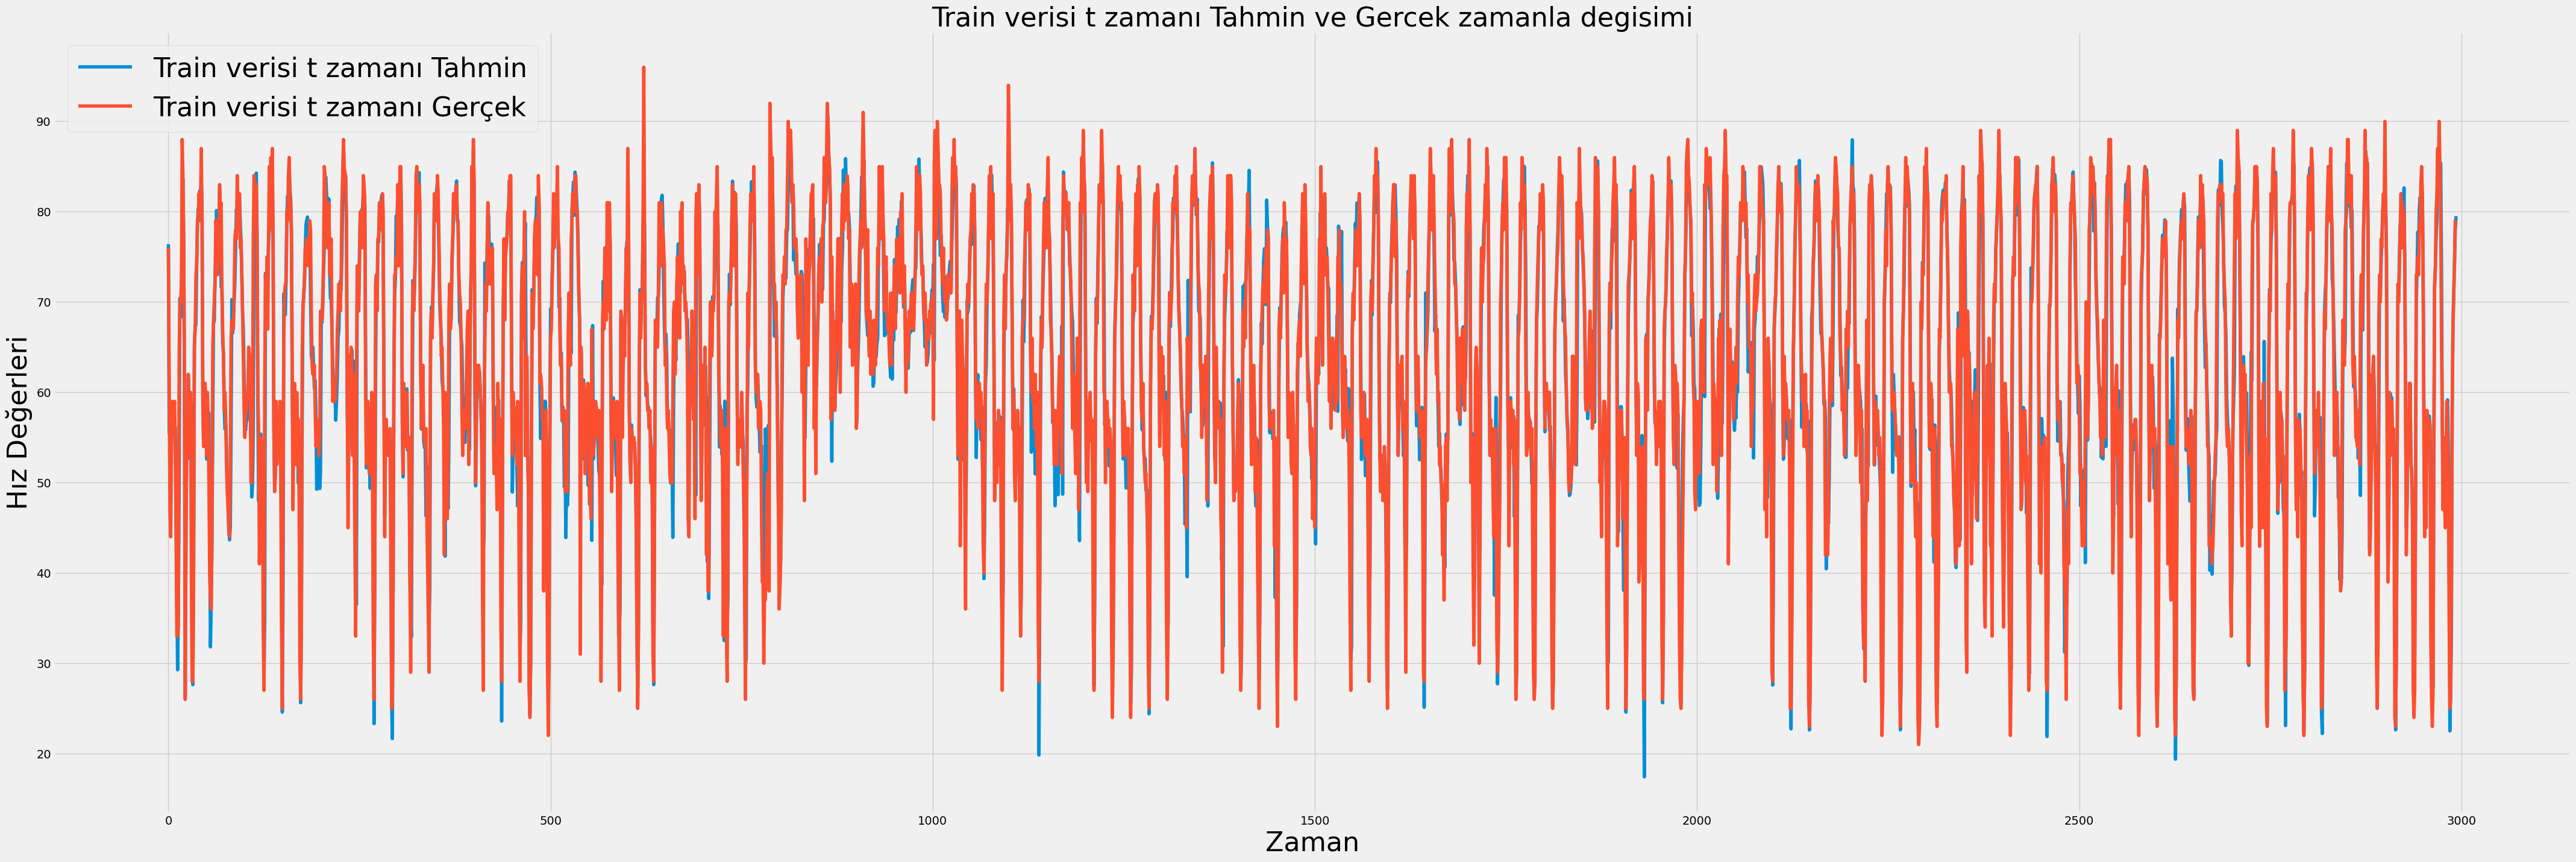

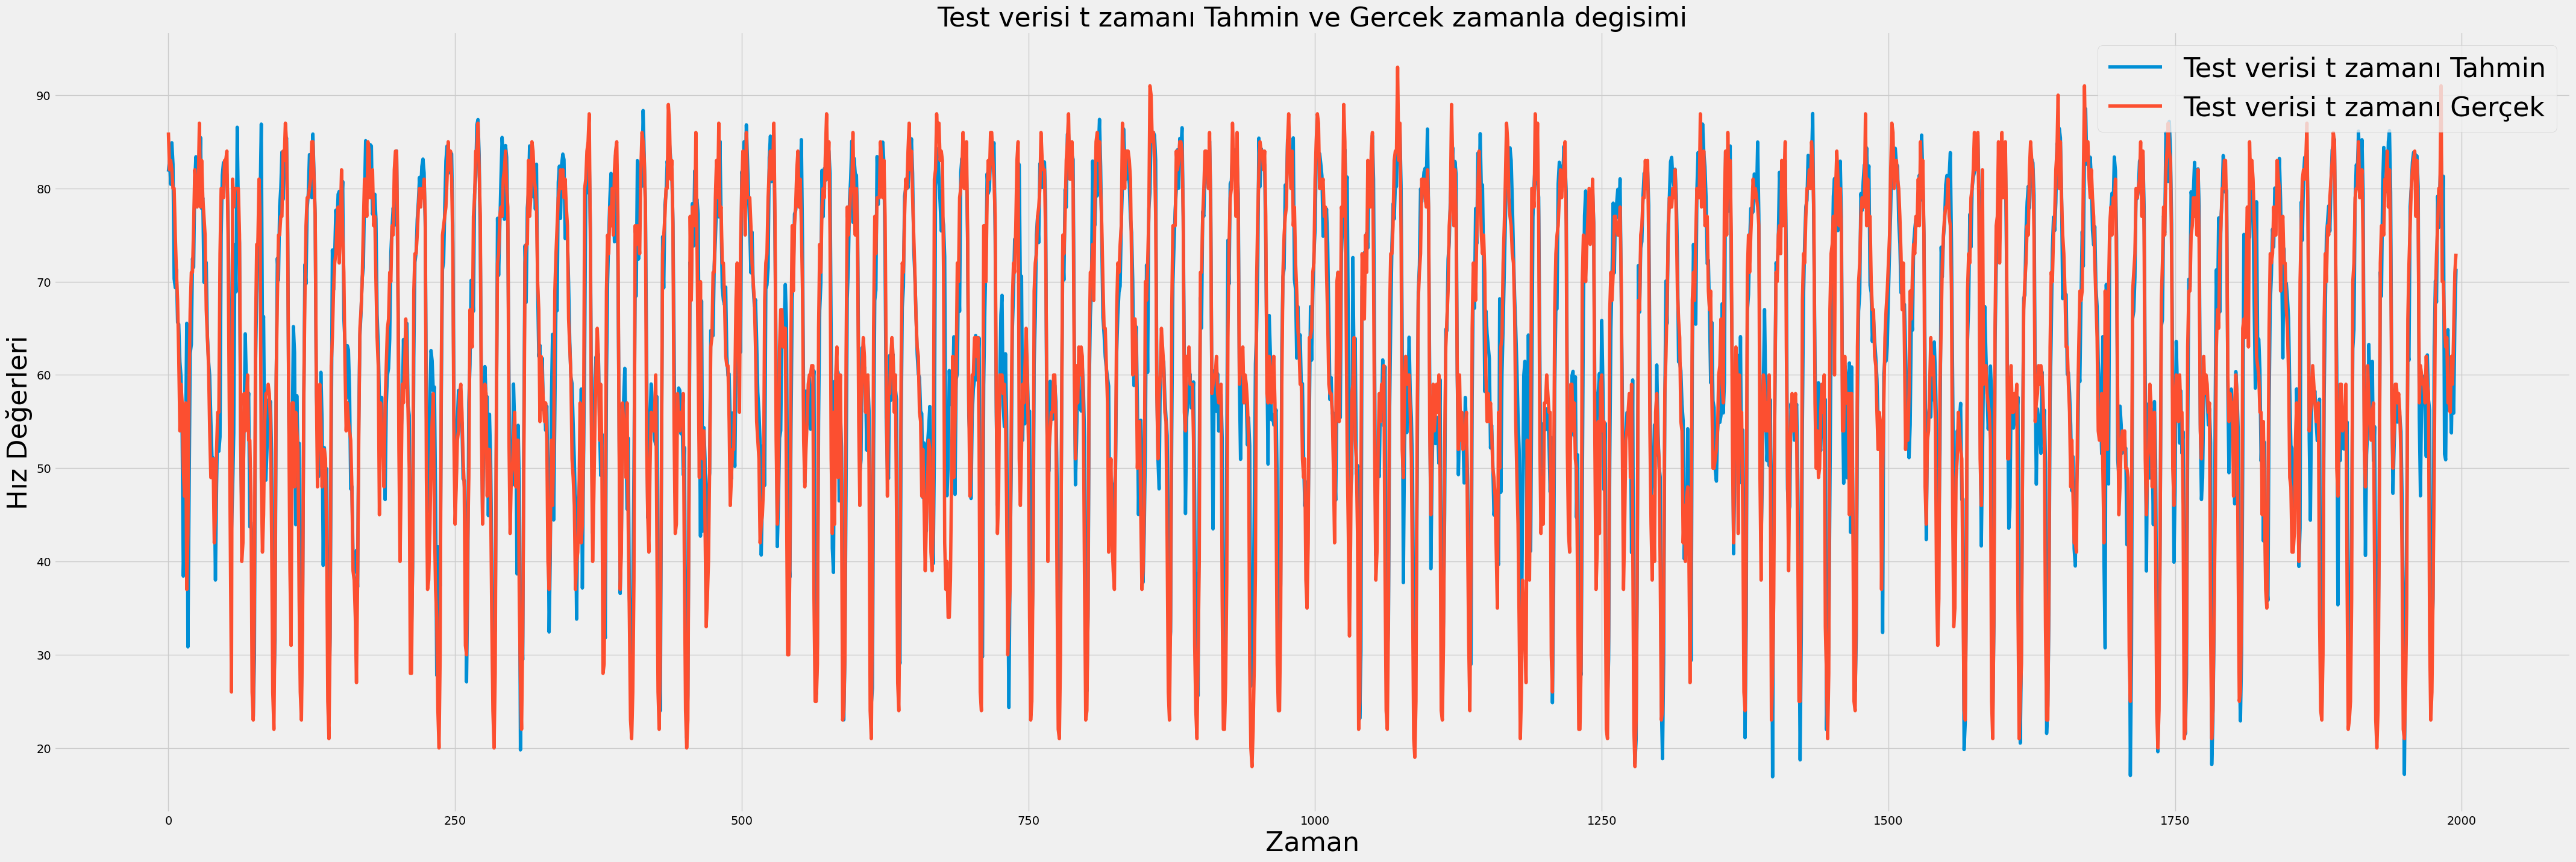

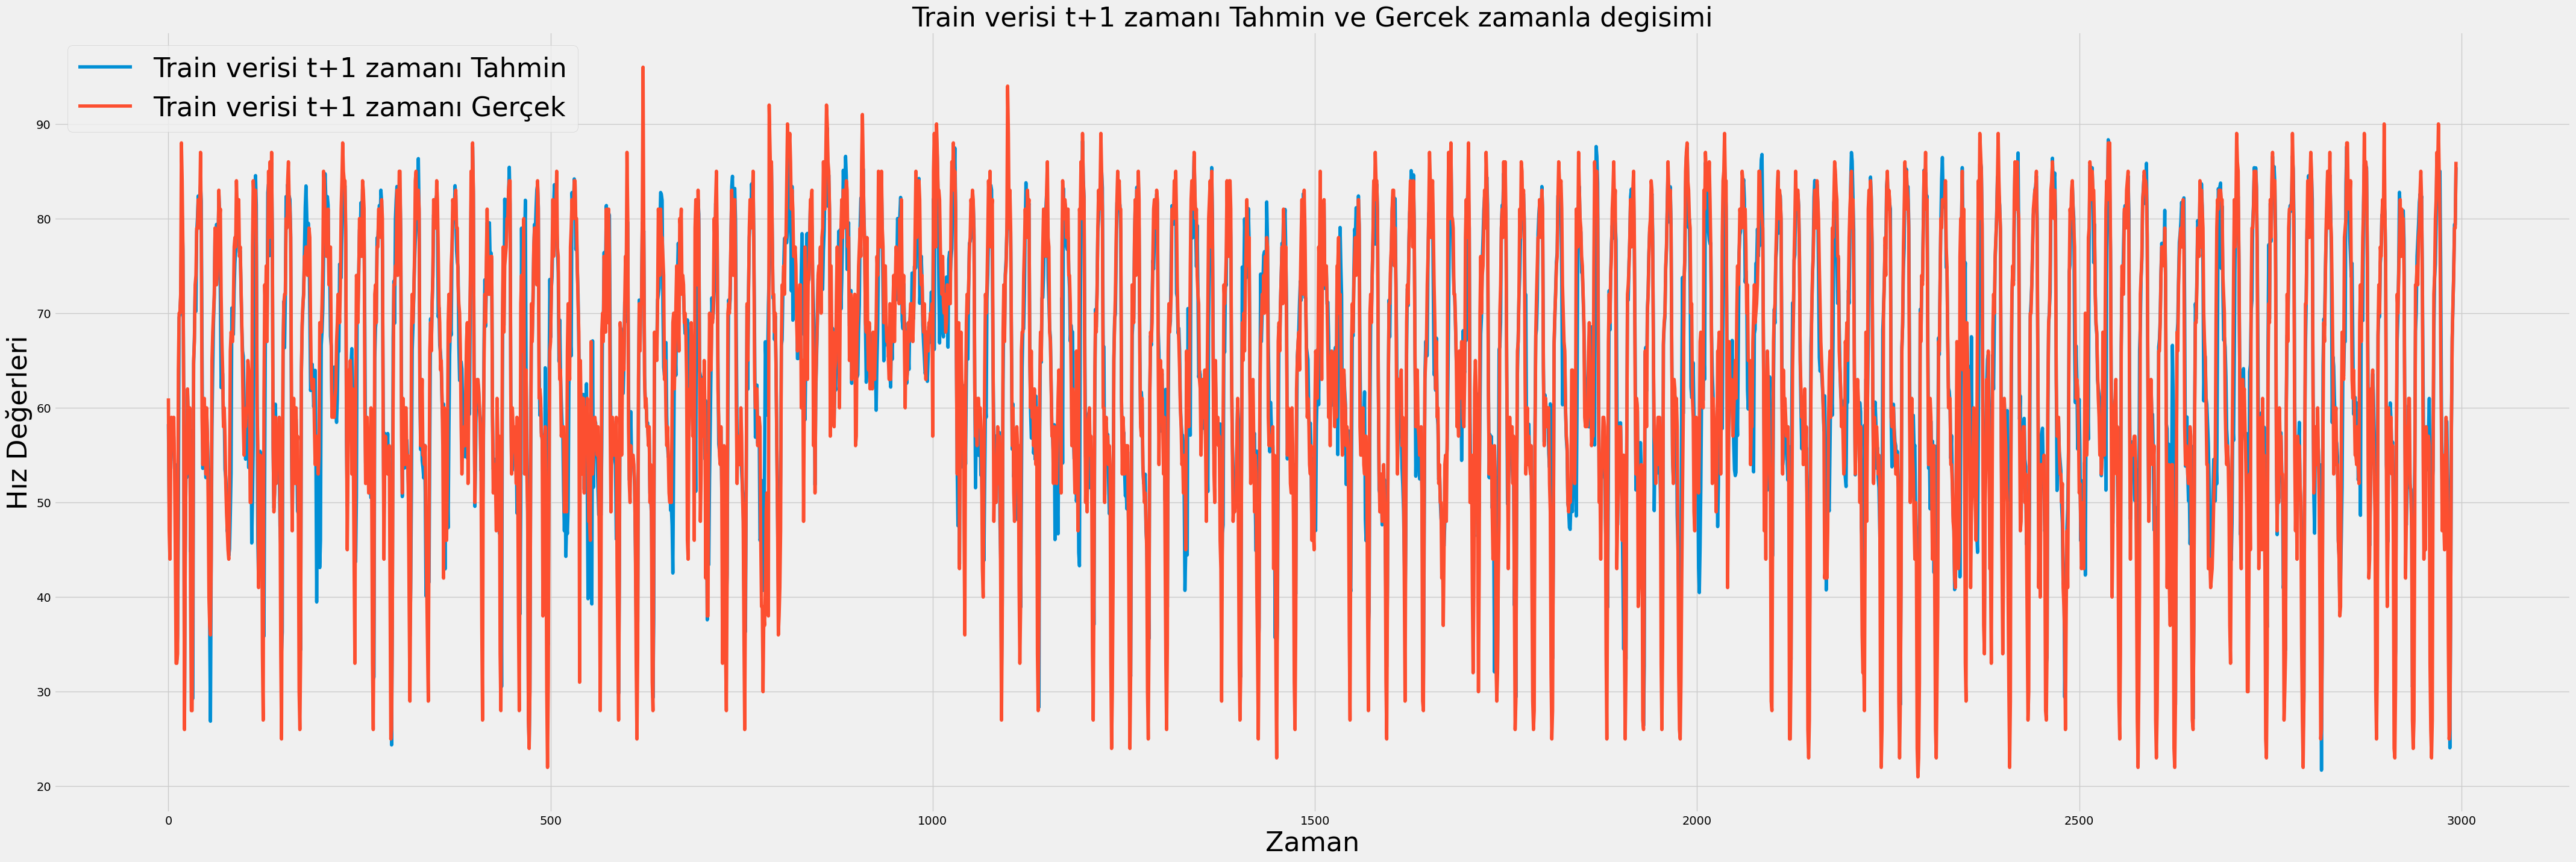

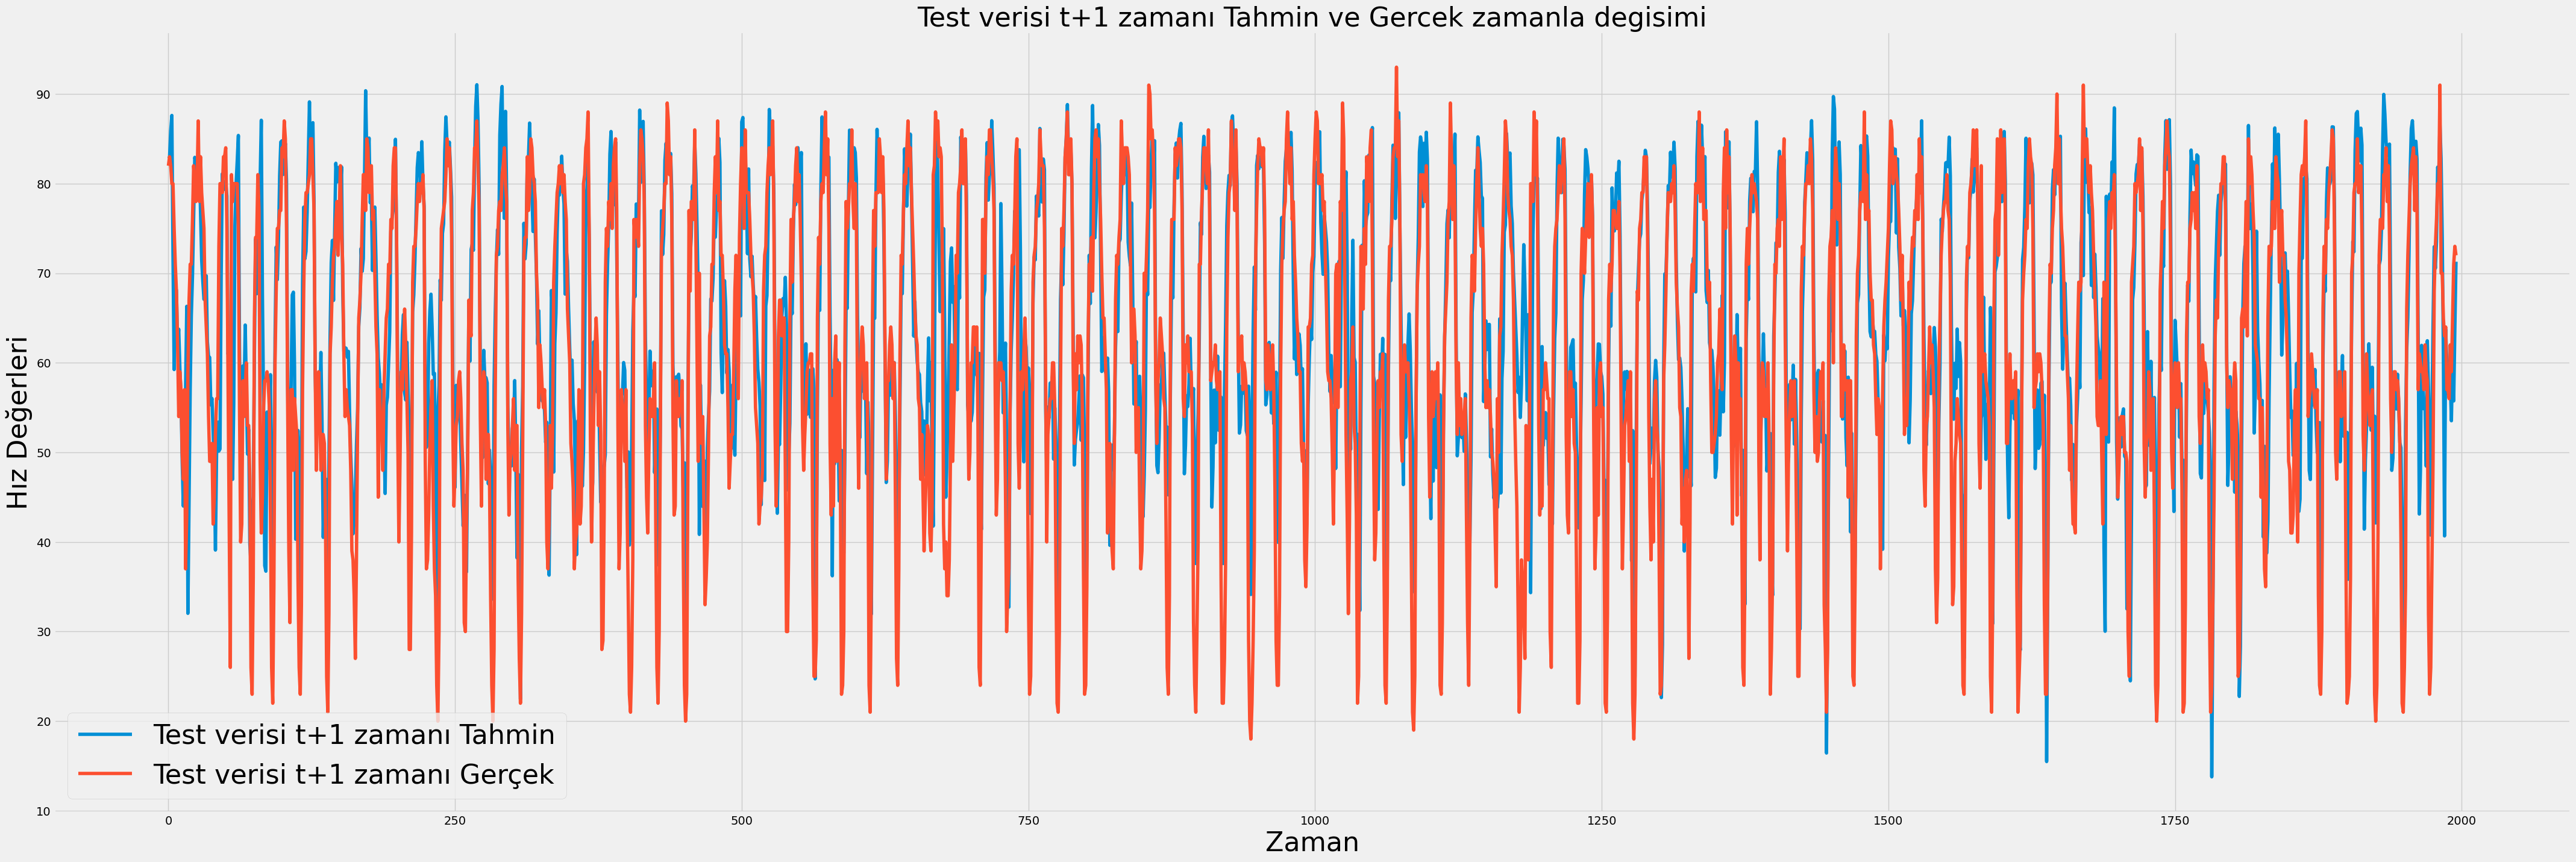

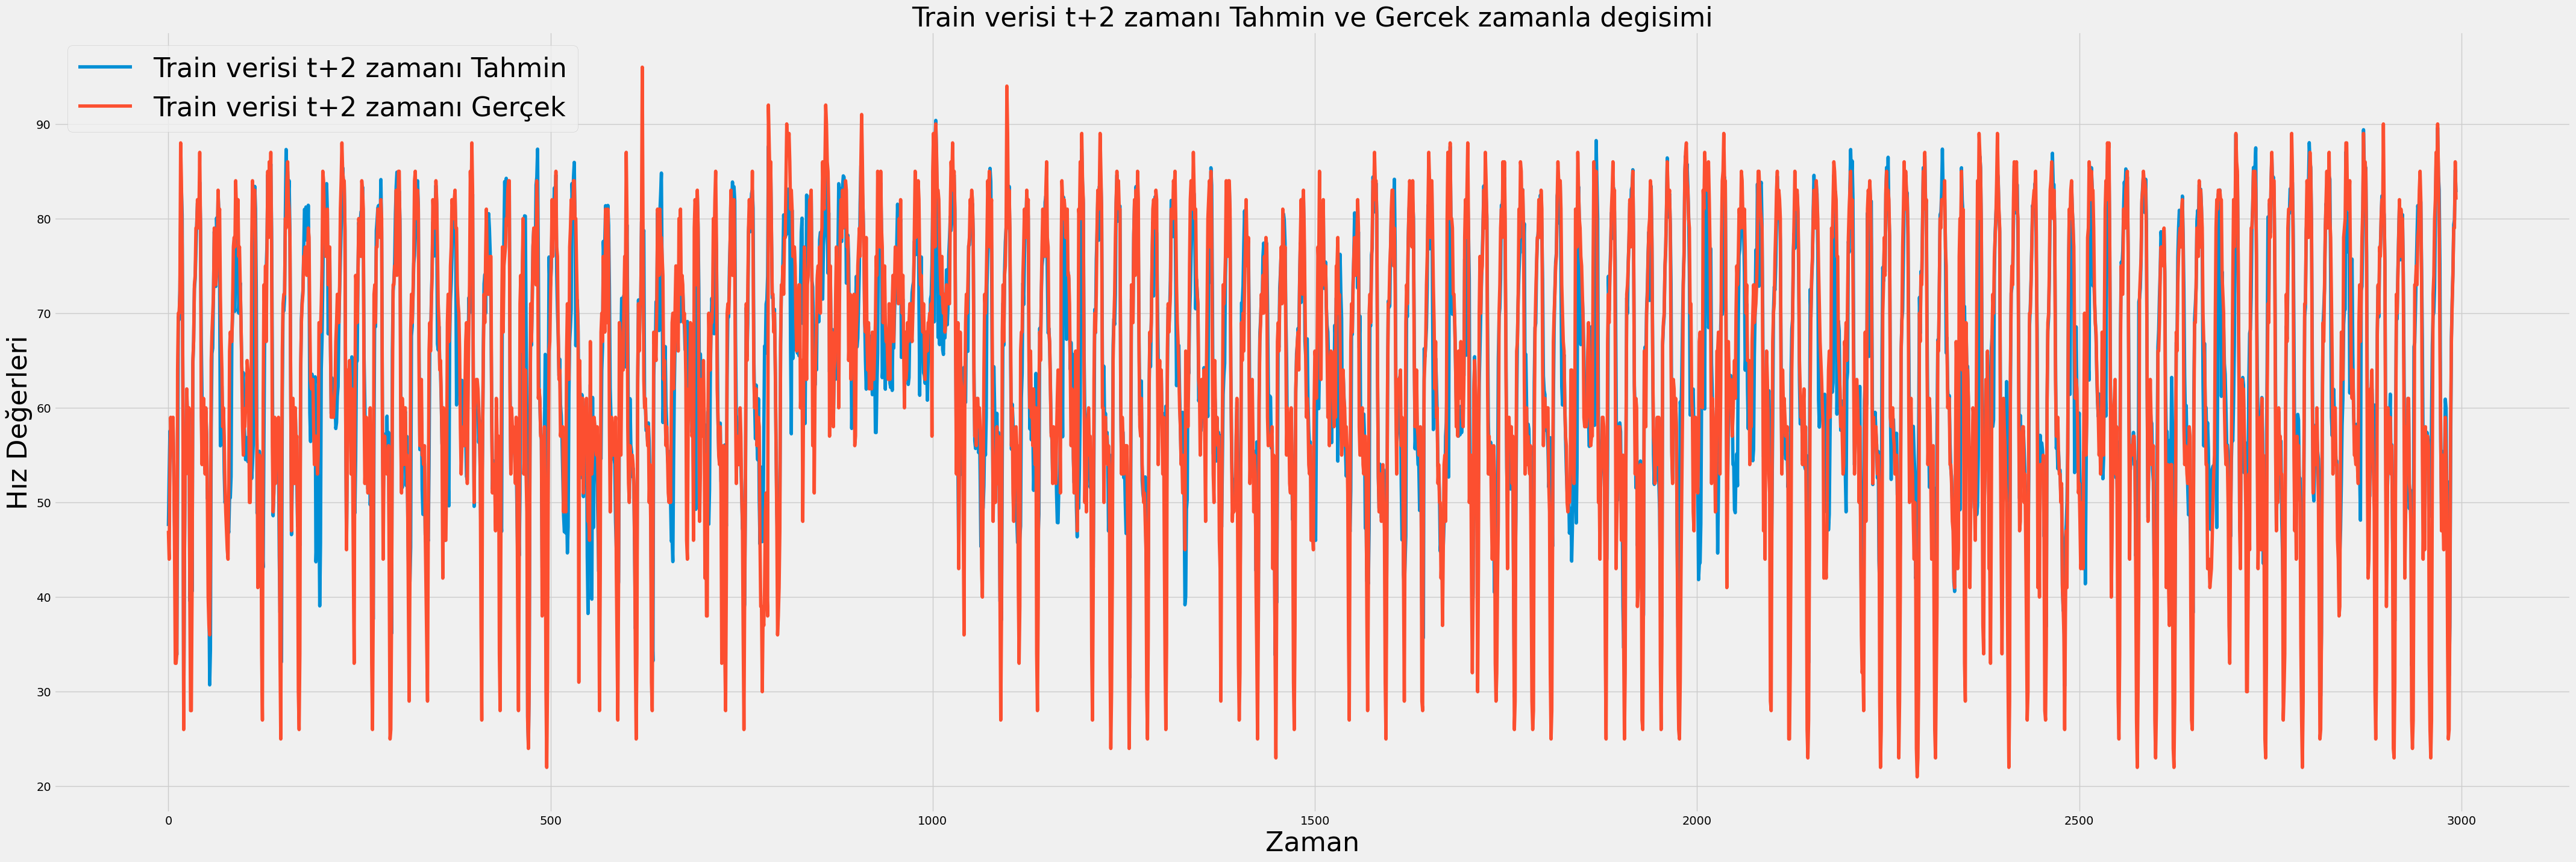

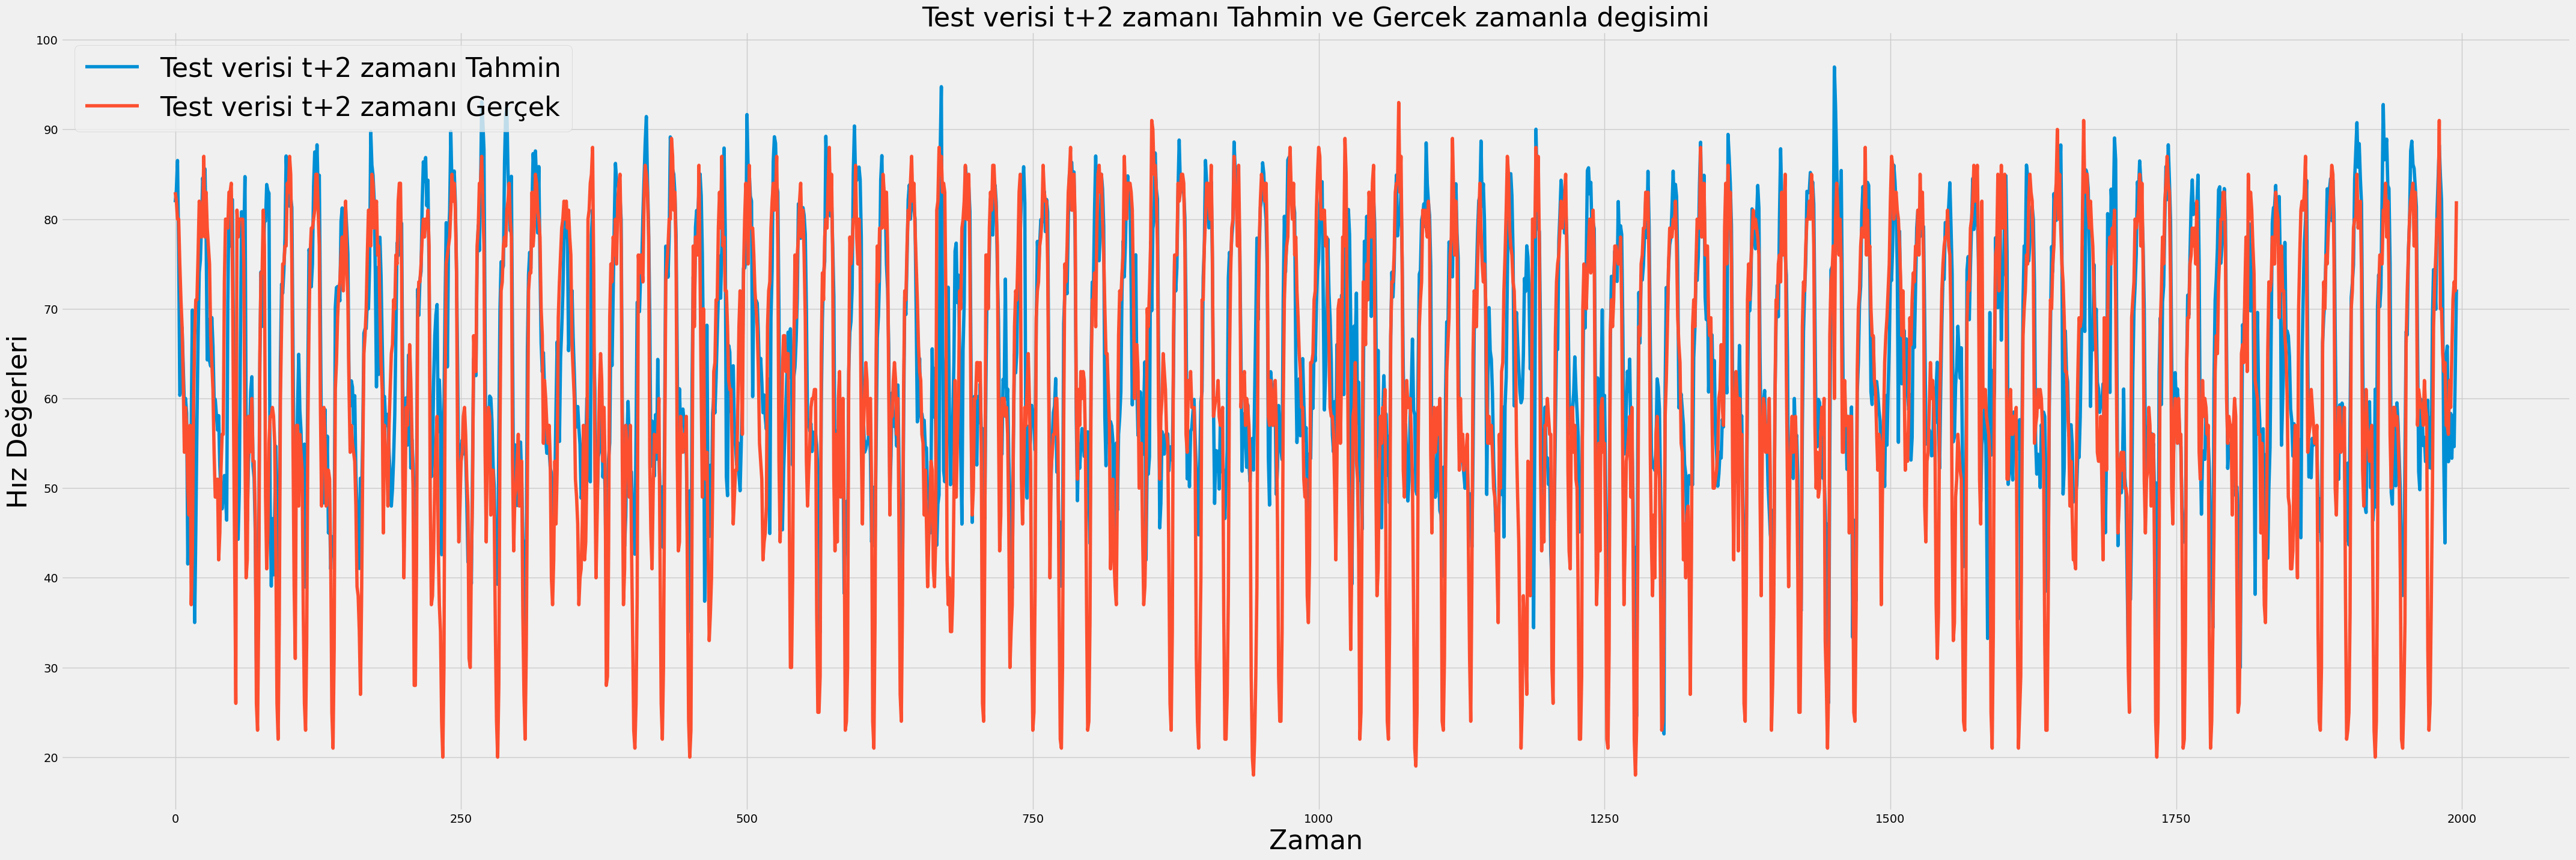

In [18]:
train_y1=train_y[:,0]
pred_train_y1=pred_train_y[:,0]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y1, label = "Train verisi t zamanı Tahmin")
plt.plot(train_y1, label = "Train verisi t zamanı Gerçek")
plt.title('Train verisi t zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

test_y1=test_y[:,0]
pred_test_y1=pred_test_y[:,0]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y1, label = "Test verisi t zamanı Tahmin")
plt.plot(test_y1, label = "Test verisi t zamanı Gerçek")
plt.title('Test verisi t zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

train_y2=train_y[:,1]
pred_train_y2=pred_train_y[:,1]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y2, label = "Train verisi t+1 zamanı Tahmin")
plt.plot(train_y2, label = "Train verisi t+1 zamanı Gerçek")
plt.title('Train verisi t+1 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')


test_y2=test_y[:,1]
pred_test_y2=pred_test_y[:,1]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y2, label = "Test verisi t+1 zamanı Tahmin")
plt.plot(test_y2, label = "Test verisi t+1 zamanı Gerçek")
plt.title('Test verisi t+1 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

train_y3=train_y[:,2]
pred_train_y3=pred_train_y[:,2]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y3, label = "Train verisi t+2 zamanı Tahmin")
plt.plot(train_y3, label = "Train verisi t+2 zamanı Gerçek")
plt.title('Train verisi t+2 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')


test_y3=test_y[:,2]
pred_test_y3=pred_test_y[:,2]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y3, label = "Test verisi t+2 zamanı Tahmin")
plt.plot(test_y3, label = "Test verisi t+2 zamanı Gerçek")
plt.title('Test verisi t+2 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')